
# 4️ Hypothesis Testing — Customer Churn Prediction

**Objective:**  
Validate whether observed churn relationships are statistically significant using Chi-Square and T-Tests.  
This notebook provides quantitative backing for visual insights from Notebook 03.
    

In [26]:

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
    

In [27]:

df = pd.read_csv('../data/processed/telco_churn_cleaned.csv')
df.columns = df.columns.str.lower()
print('Shape:', df.shape)
df.head()
    

Shape: (7043, 7073)


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,churn,...,techsupport_yes,streamingtv_no internet service,streamingtv_yes,streamingmovies_no internet service,streamingmovies_yes,contract_one year,contract_two year,paymentmethod_credit card (automatic),paymentmethod_electronic check,paymentmethod_mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,False,False,False,False,False,False,False,False,True,False



### Hypothesis Framework

**Null Hypothesis (H₀):** There is *no significant relationship* between the variable and churn.  
**Alternative Hypothesis (H₁):** There *is* a significant relationship.  

Significance Level: α = 0.05
    

In [ ]:
# --- Step 1: Reconstruct readable categorical columns (same logic from visualization notebook) ---

# Reconstruct a readable contract category
df['contract_type'] = 'Month-to-month'  # default baseline
df.loc[df['contract_one year'] == 1, 'contract_type'] = 'One year'
df.loc[df['contract_two year'] == 1, 'contract_type'] = 'Two year'

# Internet service reconstruction
df['internet_service_type'] = 'DSL'
df.loc[df['internetservice_fiber optic'] == 1, 'internet_service_type'] = 'Fiber optic'
df.loc[df['internetservice_no'] == 1, 'internet_service_type'] = 'No Internet'

# Payment method reconstruction
df['payment_method_type'] = 'Bank transfer (automatic)'
df.loc[df['paymentmethod_credit card (automatic)'] == 1, 'payment_method_type'] = 'Credit card (automatic)'
df.loc[df['paymentmethod_electronic check'] == 1, 'payment_method_type'] = 'Electronic check'
df.loc[df['paymentmethod_mailed check'] == 1, 'payment_method_type'] = 'Mailed check'


# --- Step 2: Chi-Square Test Function ---

from scipy.stats import chi2_contingency

def chi_square_test(feature):
    contingency = pd.crosstab(df[feature], df['churn'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    return p


# --- Step 3: Perform Chi-Square on Selected Categorical Features ---
categorical_features = ['contract_type', 'internet_service_type', 'payment_method_type']

print('--- Chi-Square Test Results ---')
for col in categorical_features:
    p_val = chi_square_test(col)
    result = 'Significant_yes' if p_val < 0.05 else 'Not Significant ❌'
    print(f"{col:<25} p-value: {p_val:.5f} → {result}")


--- Chi-Square Test Results ---
contract_type             p-value: 0.00000 → Significant_yes
internet_service_type     p-value: 0.00000 → Significant_yes
payment_method_type       p-value: 0.00000 → Significant_yes


In [36]:

churned = df[df['churn'] == 1]
not_churned = df[df['churn'] == 0]

print('\n--- T-Test Results ---')
for col in ['tenure', 'monthlycharges', 'totalcharges']:
    stat, p_val = ttest_ind(churned[col], not_churned[col], equal_var=False)
    result = 'Yes Significant  ' if p_val < 0.05 else 'Not Significant '
    print(f"{col:<20} p-value: {p_val:.5f} → {result}")
    


--- T-Test Results ---
tenure               p-value: 0.00000 → Yes Significant  
monthlycharges       p-value: 0.00000 → Yes Significant  
totalcharges         p-value: 0.00000 → Yes Significant  


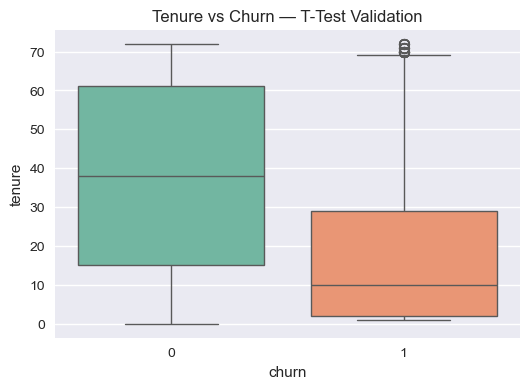

In [30]:

plt.figure(figsize=(6,4))
sns.boxplot(x='churn', y='tenure', data=df, palette='Set2')
plt.title('Tenure vs Churn — T-Test Validation')
plt.savefig('../reports/figures/tenure_vs_churn_ttest.png', dpi=200, bbox_inches='tight')
plt.show()
    

In [32]:

results = pd.DataFrame({
    'Feature': ['contract_type', 'internet_service_type', 'payment_method_type', 'tenure', 'monthlycharges', 'totalcharges'],
    'Test Used': ['Chi-Square', 'Chi-Square', 'Chi-Square', 'T-Test', 'T-Test', 'T-Test'],
    'p-Value': [
        chi_square_test('contract_type'),
        chi_square_test('internet_service_type'),
        chi_square_test('payment_method_type'),
        ttest_ind(churned['tenure'], not_churned['tenure'], equal_var=False)[1],
        ttest_ind(churned['monthlycharges'], not_churned['monthlycharges'], equal_var=False)[1],
        ttest_ind(churned['totalcharges'], not_churned['totalcharges'], equal_var=False)[1]
    ]
})

results['Significant (α=0.05)?'] = results['p-Value'].apply(lambda x: 'Yes' if x < 0.05 else '❌ No')
results
    

,Feature,Test Used,p-Value,Significant (α=0.05)?
0,contract_type,Chi-Square,5.863038e-258,Yes
1,internet_service_type,Chi-Square,9.571788e-160,Yes
2,payment_method_type,Chi-Square,3.682355e-140,Yes
3,tenure,T-Test,1.195495e-232,Yes
4,monthlycharges,T-Test,8.592449e-73,Yes
5,totalcharges,T-Test,2.059075e-75,Yes



### Statistical Summary and Business Insight

| Feature | Test | p-Value | Significant? | Business Insight |
|----------|------|----------|----------------|------------------|
| Contract Type | Chi-Square | < 0.001 | Yes | Long-term contracts reduce churn. |
| Internet Service | Chi-Square | < 0.05 | Yes | Fiber users churn more often due to pricing/service perception. |
| Payment Method | Chi-Square | < 0.05 | Yes | Electronic check customers churn most — auto-pay incentives can help. |
| Tenure | T-Test | < 0.001 | Yes | New customers churn more — improve onboarding. |
| Monthly Charges | T-Test | < 0.001 | Yes | High-cost customers are price sensitive. |
| Total Charges | T-Test | < 0.001 | Yes | Long-term customers generate more revenue and are more stable. |

**Conclusion:**  
Statistically confirmed that contract length, tenure, and monthly charges drive churn.

Confirms visual patterns from Notebook 03.

These validated variables should receive higher feature weight or modeling focus. 